In [25]:
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.schema import Document
from langchain.vectorstores import Milvus
import os

In [26]:
from tqdm import tqdm

In [27]:
dir_path = os.getcwd()
dir_path

'/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search'

In [28]:
# class HuggingFaceEmbeddings(BaseModel, Embeddings):
#     """HuggingFace sentence_transformers embedding models.

#     To use, you should have the ``sentence_transformers`` python package installed.

#     Example:
#         .. code-block:: python

#             from langchain.embeddings import HuggingFaceEmbeddings

#             model_name = "sentence-transformers/all-mpnet-base-v2"
#             model_kwargs = {'device': 'cpu'}
#             encode_kwargs = {'normalize_embeddings': False}
#             hf = HuggingFaceEmbeddings(
#                 model_name=model_name,
#                 model_kwargs=model_kwargs,
#                 encode_kwargs=encode_kwargs
#             )
#     """

#     client: Any  #: :meta private:
#     model_name: str = DEFAULT_MODEL_NAME
#     """Model name to use."""
#     cache_folder: Optional[str] = None
#     """Path to store models.
#     Can be also set by SENTENCE_TRANSFORMERS_HOME environment variable."""
#     model_kwargs: Dict[str, Any] = Field(default_factory=dict)
#     """Keyword arguments to pass to the model."""
#     encode_kwargs: Dict[str, Any] = Field(default_factory=dict)
#     """Keyword arguments to pass when calling the `encode` method of the model."""
#     multi_process: bool = False
#     """Run encode() on multiple GPUs."""

#     def __init__(self, **kwargs: Any):
#         """Initialize the sentence_transformer."""
#         super().__init__(**kwargs)
#         try:
#             import sentence_transformers

#         except ImportError as exc:
#             raise ImportError(
#                 "Could not import sentence_transformers python package. "
#                 "Please install it with `pip install sentence-transformers`."
#             ) from exc

#         self.client = sentence_transformers.SentenceTransformer(
#             self.model_name, cache_folder=self.cache_folder, **self.model_kwargs
#         )

#     class Config:
#         """Configuration for this pydantic object."""

#         extra = Extra.forbid

#     def embed_documents(self, texts: List[str]) -> List[List[float]]:
#         """Compute doc embeddings using a HuggingFace transformer model.

#         Args:
#             texts: The list of texts to embed.

#         Returns:
#             List of embeddings, one for each text.
#         """
#         import sentence_transformers

#         texts = list(map(lambda x: x.replace("\n", " "), texts))
#         if self.multi_process:
#             pool = self.client.start_multi_process_pool()
#             embeddings = self.client.encode_multi_process(texts, pool)
#             sentence_transformers.SentenceTransformer.stop_multi_process_pool(pool)
#         else:
#             embeddings = self.client.encode(texts, **self.encode_kwargs)

#         return embeddings.tolist()

#     def embed_query(self, text: str) -> List[float]:
#         """Compute query embeddings using a HuggingFace transformer model.

#         Args:
#             text: The text to embed.

#         Returns:
#             Embeddings for the text.
#         """
#         return self.embed_documents([text])[0]

In [29]:
from typing import Any, Dict, List, Optional
from geo_utils import (
    crop_middle_image_from_side_size,
    apply_circle_mask,
)
from PIL import Image

device = "mps"


def preprocess_image(image: Image.Image) -> Image.Image:
    # image = crop_middle_image_from_side_size(image, 2400, 1600)
    image = apply_circle_mask(image)
    image = image.resize((512, 512))
    return image


def predict(
    model,
    transforms,
    image_path,
    debug_save_path=None,
    device=device,
    preprocess_image=preprocess_image,
):
    image = Image.open(image_path).convert("RGB")
    preprocessed_image = preprocess_image(image)
    image_tensor = (
        transforms(preprocessed_image).unsqueeze(0).to(device)
    )  # Move input data to the GPU
    # output = model(image_tensor)

    # or equivalently (without needing to set num_classes=0)
    output = model.forward_features(image_tensor)
    output = model.forward_head(output, pre_logits=True)
    embedding = output.detach().cpu().numpy()[0]
    if debug_save_path:
        preprocessed_image.save(debug_save_path)
    # save preprocessed_image
    return embedding


import timm


class ImageEmbedding:
    def __init__(
        self, model_name: str = "maxvit_tiny_tf_512.in1k", device: str = "mps"
    ):
        """Initialize the sentence_transformer."""
        self.device = device
        self.model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,  # remove classifier nn.Linear
        ).to(self.device)
        self.model = self.model.eval()
        data_config = timm.data.resolve_model_data_config(self.model)
        transforms = timm.data.create_transform(**data_config, is_training=False)
        self.transforms = transforms

    def embed_documents(
        self,
        image_paths: List[str],
        preprocess_image=preprocess_image,
    ) -> List[List[float]]:
        """Compute doc embeddings using a HuggingFace transformer model.

        Args:
            image_paths: The list of image_path to embed.

        Returns:
            List of embeddings, one for each text.
        """
        embeddings = []
        for image_path in tqdm(image_paths, desc="Processing images"):
            embedding = predict(
                model=self.model,
                transforms=self.transforms,
                image_path=image_path,
                preprocess_image=preprocess_image,
            )

            embeddings.append(embedding)
        return embeddings

    def embed_query(self, text: str, preprocess_image=preprocess_image) -> List[float]:
        """Compute query embeddings using a HuggingFace transformer model.

        Args:
            text: The text to embed.

        Returns:
            Embeddings for the text.
        """
        return self.embed_documents([text], preprocess_image=preprocess_image)[0]

In [30]:
embeddings = ImageEmbedding()

In [31]:
def custom_preprocess_image(image: Image.Image, rotation=90) -> Image.Image:
    # image = crop_middle_image_from_side_size(image, 2400, 1600)
    image = apply_circle_mask(image)
    image = image.rotate(rotation)
    image = image.resize((512, 512))
    return image

In [32]:
image_path = "/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/7.png"
query_result = embeddings.embed_query(
    image_path, preprocess_image=custom_preprocess_image
)

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [33]:
print(len(query_result))
query_result[:10]

512


array([-0.44327304, -0.44441557, -0.42114004, -0.6397424 , -0.71184504,
        0.710712  , -0.6399176 ,  0.80740786, -0.05907254,  0.8779193 ],
      dtype=float32)

In [34]:
print(len(query_result))
query_result[:10]

512


array([-0.44327304, -0.44441557, -0.42114004, -0.6397424 , -0.71184504,
        0.710712  , -0.6399176 ,  0.80740786, -0.05907254,  0.8779193 ],
      dtype=float32)

In [35]:
image_folder = f"{dir_path}/crop_image"
image_paths = [f"{image_folder}/{i}" for i in os.listdir(image_folder)]
image_paths[:10]

['/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/348.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/12085.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/1804.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/4968.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/10686.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/12091.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/15098.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/6819.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8834.png

In [36]:
TEST = False
# TEST = True


docs = []
for ind, image_path in enumerate(image_paths):
    docs.append(
        Document(
            page_content=image_path,
            # metadata={
            #     "keyword": ori_df["keyword"][i],
            #     "sentiment_label": ori_df["sentiment_label"][i],
            #     "sentiment_predict": ori_df["sentiment_predict"][i],
            #     "sentence_length": len(ori_df["sentence"][i]),
            # },
        )
    )
if TEST:
    docs = docs[:100]
    collection_name = "reverse_image_search_milvus_test"
else:
    collection_name = "reverse_image_search_milvus"
collection_name, len(docs), docs[0]

('reverse_image_search_milvus',
 11118,
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png'))

In [37]:
# check if collection exists
try:
    vector_store = Milvus(
        embeddings,
        connection_args={"host": "127.0.0.1", "port": 19530},
        collection_name=collection_name,
    )
    input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/18564.png"
    search_results = vector_store.similarity_search(
        query=input_image_path,
        k=10,
        # where_filter={"keyword": "เสื้อ"},
    )
    if search_results == []:
        raise Exception("collection not exists")
    print("collection exists")
except Exception as e:
    vector_store = Milvus.from_documents(
        docs,
        embedding=embeddings,
        collection_name=collection_name,
        connection_args={"host": "localhost", "port": 19530},
    )

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

collection exists


In [38]:
# vector_store = Milvus.from_documents(
#     docs,
#     embedding=embeddings,
#     collection_name=collection_name,
#     connection_args={"host": "localhost", "port": 19530},
# )
# # expect time ~150 mins

In [40]:
input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/18564.png"
search_results = vector_store.similarity_search(
    query=input_image_path,
    # k=10,
    k=100,
    # where_filter={"keyword": "เสื้อ"},
)

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
RPC error: [search], <MilvusException: (code=65538, message=failed to search: attempt #0: failed to search/query delegator 7 for channel by-dev-rootcoord-dml_10_446487859321330428v0: fail to Search, QueryNode ID=7, reason=worker(7) query failed: UnexpectedError: Assert "failed to search: out of range in json: ef(10) should be larger than k(100)" at /go/src/github.com/milvus-io/milvus/internal/core/src/index/VectorMemIndex.cpp:326: attempt #1: no available shard delegator found: service unavailable)>, <Time:{'RPC start': '2024-01-18 09:28:03.285063', 'RPC error': '2024-01-18 09:28:03.898820'}>


MilvusException: <MilvusException: (code=65538, message=failed to search: attempt #0: failed to search/query delegator 7 for channel by-dev-rootcoord-dml_10_446487859321330428v0: fail to Search, QueryNode ID=7, reason=worker(7) query failed: UnexpectedError: Assert "failed to search: out of range in json: ef(10) should be larger than k(100)" at /go/src/github.com/milvus-io/milvus/internal/core/src/index/VectorMemIndex.cpp:326: attempt #1: no available shard delegator found: service unavailable)>

In [ ]:
import time

for i in [10, 100, 1000, 10000]:
    start_time = time.time()
    input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/18564.png"
    search_results = vector_store.similarity_search(
        query=input_image_path,
        k=i,
        # where_filter={"keyword": "เสื้อ"},
    )
    print(f"search {i} images time: {time.time() - start_time}")

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


search 10 images time: 0.7952439785003662


Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
RPC error: [search], <MilvusException: (code=65538, message=failed to search: attempt #0: failed to search/query delegator 7 for channel by-dev-rootcoord-dml_10_446487859321330428v0: fail to Search, QueryNode ID=7, reason=worker(7) query failed: UnexpectedError: Assert "failed to search: out of range in json: ef(10) should be larger than k(100)" at /go/src/github.com/milvus-io/milvus/internal/core/src/index/VectorMemIndex.cpp:326: attempt #1: no available shard delegator found: service unavailable)>, <Time:{'RPC start': '2024-01-18 09:01:35.157142', 'RPC error': '2024-01-18 09:01:35.773645'}>


MilvusException: <MilvusException: (code=65538, message=failed to search: attempt #0: failed to search/query delegator 7 for channel by-dev-rootcoord-dml_10_446487859321330428v0: fail to Search, QueryNode ID=7, reason=worker(7) query failed: UnexpectedError: Assert "failed to search: out of range in json: ef(10) should be larger than k(100)" at /go/src/github.com/milvus-io/milvus/internal/core/src/index/VectorMemIndex.cpp:326: attempt #1: no available shard delegator found: service unavailable)>

In [ ]:
search_results

[Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/18564.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/7596.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/2215.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/11821.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9451.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/13110.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8446.png'),
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9061.png'),
 Document(pag

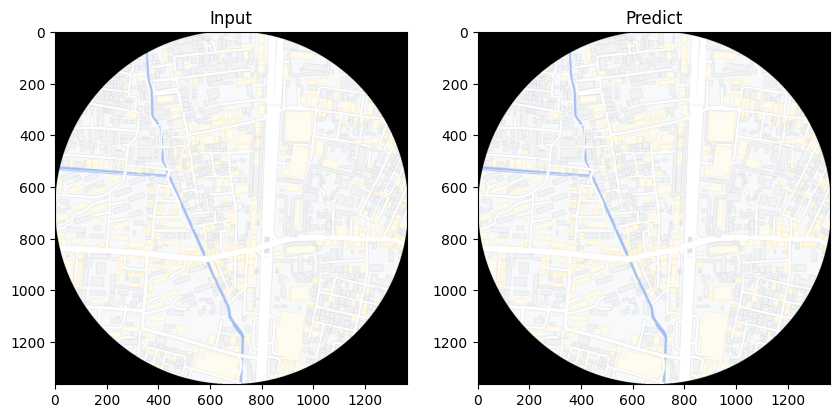

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


def show_image_result(image_path, fig_size=(10, 10), input_image_path=input_image_path):
    fig, axes = plt.subplots(1, 2, figsize=fig_size)

    # Load input image
    input_image = Image.open(input_image_path)
    axes[0].imshow(input_image)
    axes[0].set_title("Input")

    # Load search result image
    image = Image.open(image_path)
    axes[1].imshow(image)
    axes[1].set_title("Predict")

    plt.show()


for search_result in search_results:
    image_path = search_result.page_content
    show_image_result(image_path)
    break

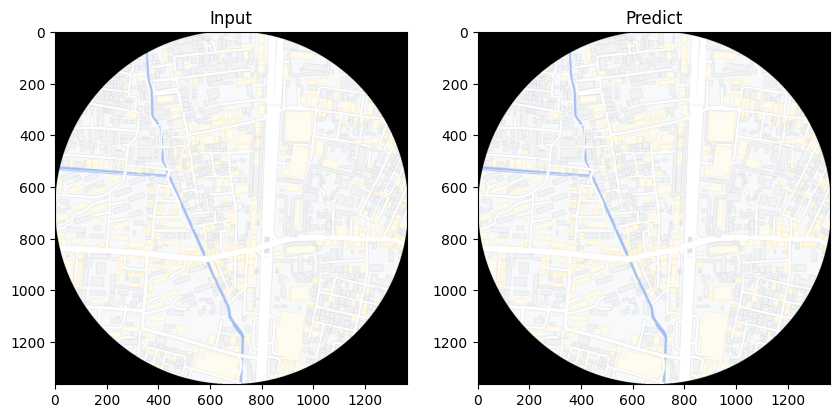

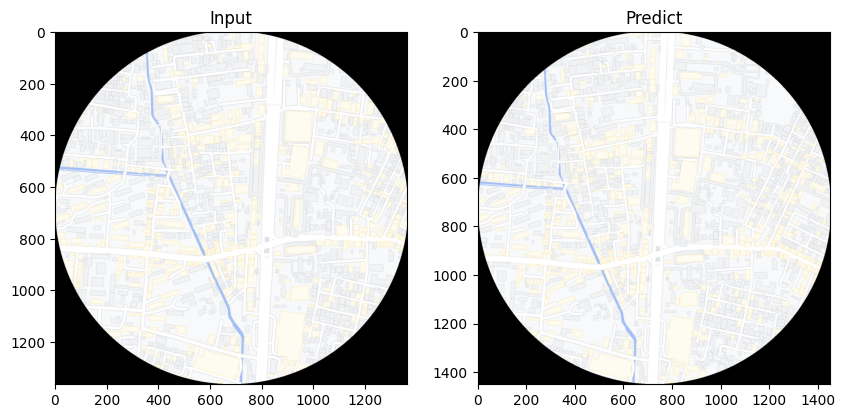

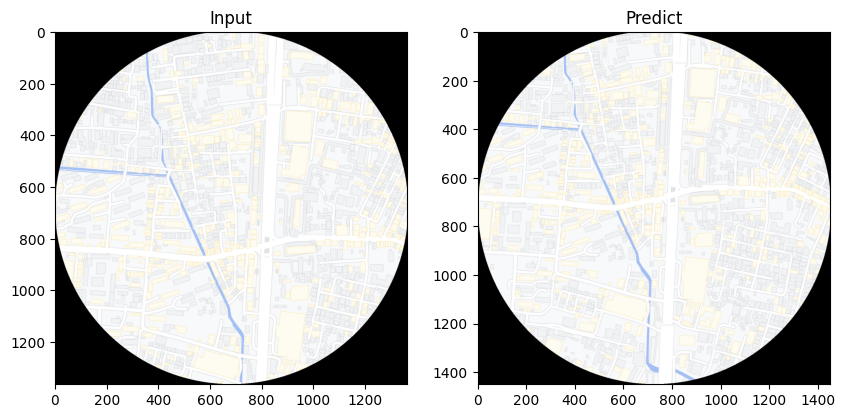

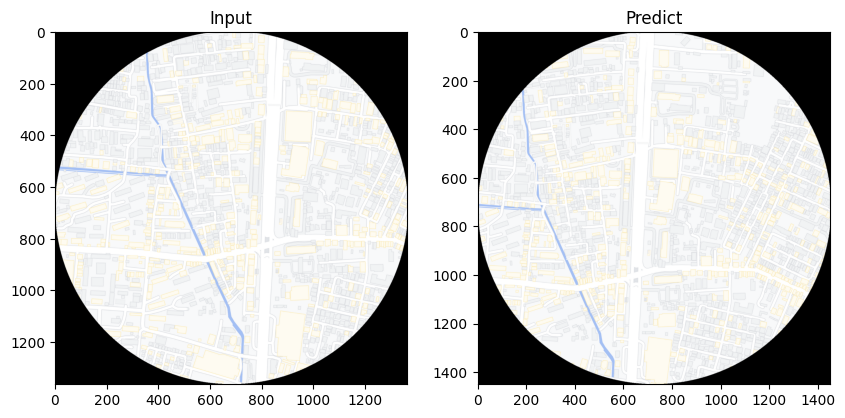

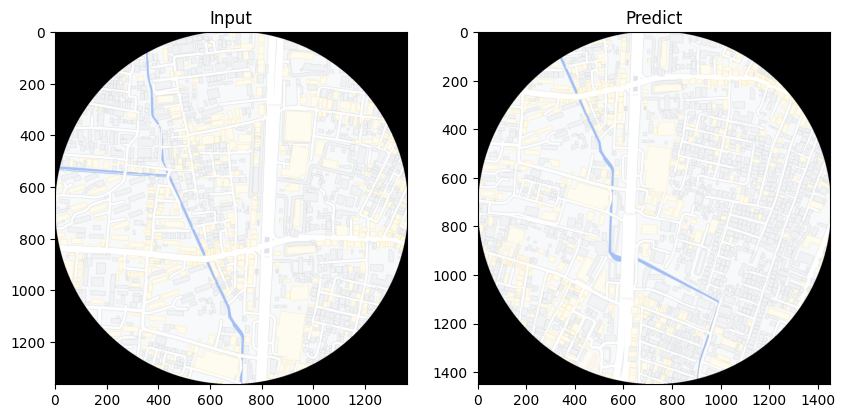

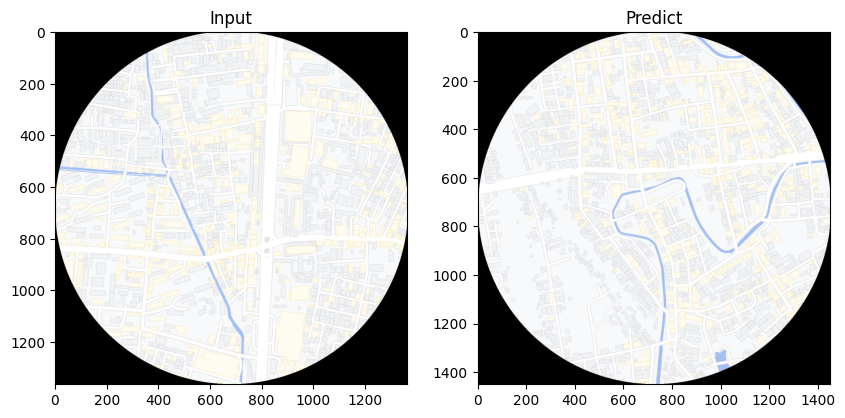

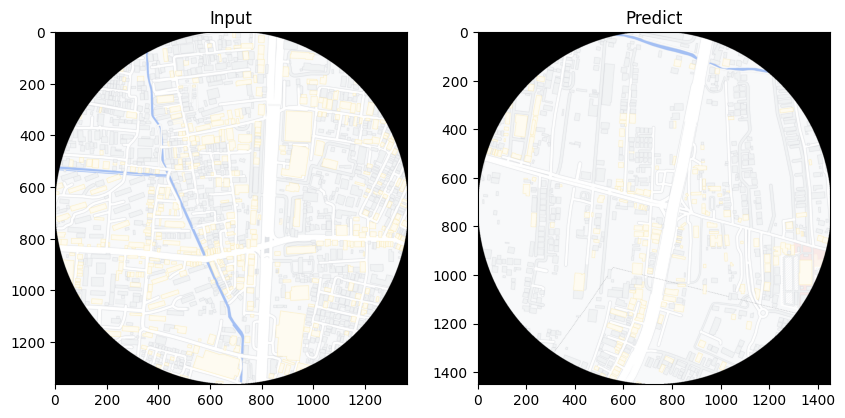

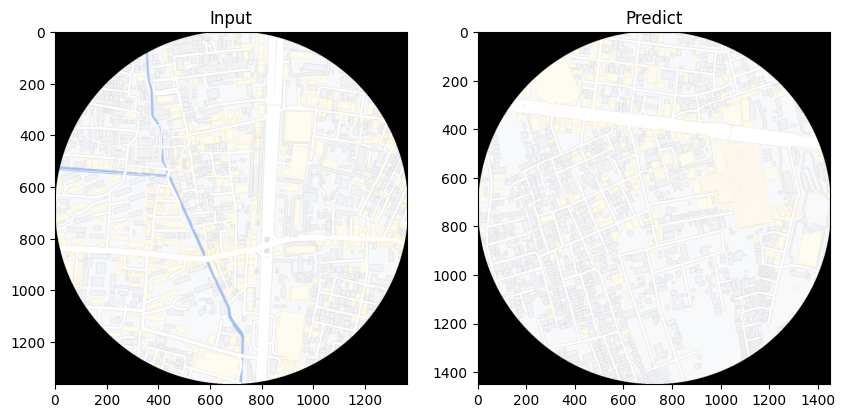

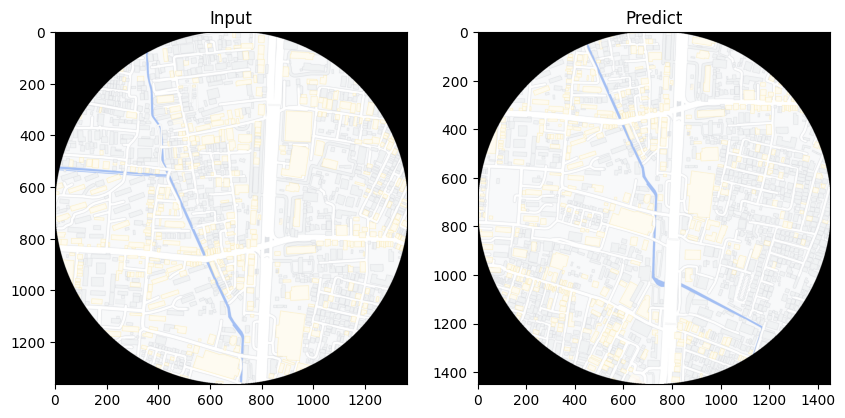

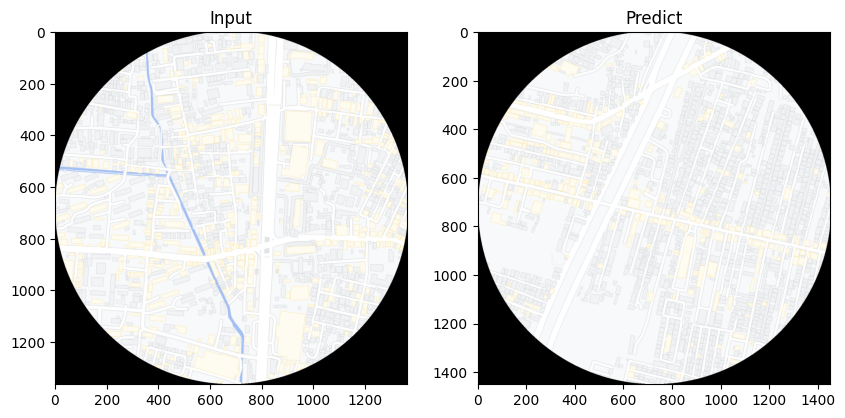

In [ ]:
for search_result in search_results:
    image_path = search_result.page_content
    image = Image.open(image_path)
    show_image_result(image_path)